In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [2]:
epochs = 500
batch_size = 100
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('다음 장치를 사용합니다:', device)

다음 장치를 사용합니다: cuda


In [3]:
trainset = datasets.FashionMNIST('./.data', train=True, download=True, transform=transforms.Compose([
                        transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))
]))

train_loader = torch.utils.data.DataLoader(dataset= trainset, batch_size=batch_size, shuffle=True)


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh()
)

In [5]:
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [6]:
# 모델의 가중치를 지정한 장치로 보내기
G = G.to(device)
D = D.to(device)

criterion = nn.BCELoss() # 이진 교차 엔트로피 오차 함수
g_optimizer = optim.Adam(G.parameters(), lr=0.0002) # 생성자와 판별자를 최적화할 Adam 모듈
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)

In [7]:
total_step = len(train_loader)

for epoch in range(epochs):
  for i, (images, _) in enumerate(train_loader):
    images = images.reshape(batch_size, -1).to(device)
    
    # '진짜'와 '가짜' 레이블 생성
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    # 무작위 텐서로 가짜 이미지 생성
    z = torch.randn(batch_size, 64).to(device)
    fake_images = G(z)

    # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # 진짜 이미지 오차와 가짜 이미지 오차를 더해서 판별자의 오차 계산
    d_loss = d_loss_real + d_loss_fake

    # 역전파 알고리즘으로 판별자 모델의 학습을 진행
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    # 생성자가 판별자를 속였는지에 대한 오차 계산
    fake_images = G(z)
    outputs = D(fake_images)
    g_loss = criterion(outputs, real_labels)
    
    # 역전파 알고리즘으로 생성자 모델의 학습을 진행
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

  print('Epoch [{}/{}] d_loss: {:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)): {:.2f}'.format(
                  epoch, epochs, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()
    ))

Epoch [0/500] d_loss: 0.0173 g_loss: 5.8291 D(x):0.99 D(G(z)): 0.01
Epoch [1/500] d_loss: 0.0512 g_loss: 5.3510 D(x):0.98 D(G(z)): 0.02
Epoch [2/500] d_loss: 0.0149 g_loss: 5.9978 D(x):0.99 D(G(z)): 0.01
Epoch [3/500] d_loss: 0.0552 g_loss: 5.9296 D(x):0.98 D(G(z)): 0.01
Epoch [4/500] d_loss: 0.0495 g_loss: 5.9261 D(x):0.99 D(G(z)): 0.04
Epoch [5/500] d_loss: 0.0346 g_loss: 6.1508 D(x):1.00 D(G(z)): 0.03
Epoch [6/500] d_loss: 0.1543 g_loss: 3.4728 D(x):0.97 D(G(z)): 0.09
Epoch [7/500] d_loss: 0.1240 g_loss: 4.6267 D(x):0.96 D(G(z)): 0.04
Epoch [8/500] d_loss: 0.0614 g_loss: 5.8509 D(x):0.98 D(G(z)): 0.02
Epoch [9/500] d_loss: 0.2332 g_loss: 5.2622 D(x):0.92 D(G(z)): 0.02
Epoch [10/500] d_loss: 0.5112 g_loss: 3.6327 D(x):0.89 D(G(z)): 0.04
Epoch [11/500] d_loss: 0.1899 g_loss: 3.9120 D(x):0.97 D(G(z)): 0.10
Epoch [12/500] d_loss: 0.3212 g_loss: 3.7576 D(x):0.94 D(G(z)): 0.10
Epoch [13/500] d_loss: 0.3168 g_loss: 3.8986 D(x):0.89 D(G(z)): 0.07
Epoch [14/500] d_loss: 0.2901 g_loss: 5.2900

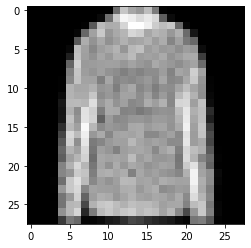

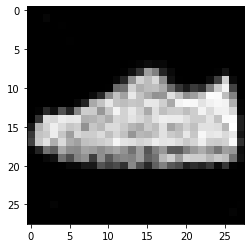

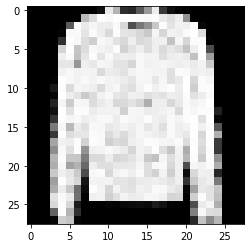

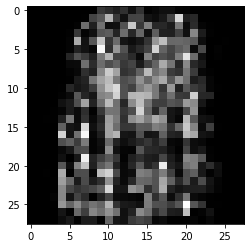

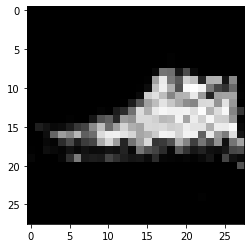

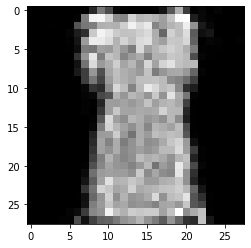

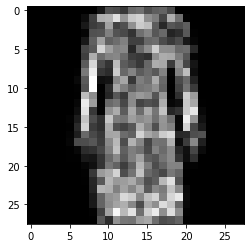

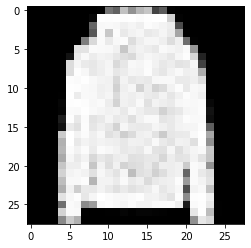

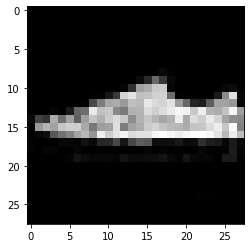

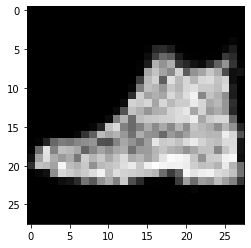

In [9]:
# 생성자가 만든 이미지 시각화
import numpy as np

z = torch.randn(batch_size, 64).to(device)
fake_images = G(z)
for i in range(10):
  fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28,28))
  plt.imshow(fake_images_img, cmap='gray')
  plt.show()